In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.filters import sobel
import glob
from tqdm import tqdm
import matplotlib as mpl
import seaborn as sns
import os
%matplotlib inline

# Raw data

Each elevation model is constructed from nine separate 1 mm resolution scans made with the SICK Ranger instrument. The scans are overlapping so that there are between three and nine measurements of bed elevation for each 1mm by 1mm grid cell. Each pass spans a maximum of 90 cm, and the data can be noisy when ambient light is reflected off the water surface. The algorithm below combines the nine noisy scans to produce a single topography model.

In [2]:
# Import example data
scanfiles = glob.glob(os.path.join('data','topography_example', '*.DAT'))

raw_data = np.empty((1501, 2688, 9), 'float')
raw_data *= np.nan

for j in range(9):
    
    # Load scan and reshape to 2D array
    with open(scanfiles[j], 'rb') as f: 
        raw = np.fromfile(f, np.float32).reshape(901, 2688) + 785
        
    # Populate raw_data matrix with scans transformed to correct position
    if j%3 == 0:
        raw_data[:901,:,j%9] = raw
    elif j%3 == 1:
        raw_data[300:1201,:,j%9] = raw
    else:
        raw_data[600:1501,:,j%9] = raw
        
raw_data[raw_data==-9214.0] = np.nan # Instrument assigns numeric value of -9214 to represent NaN

Text(500, 1200, '1 m')

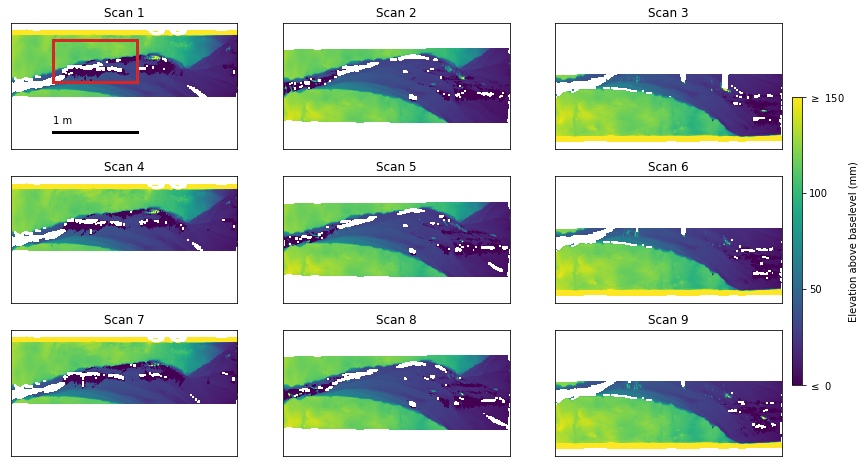

In [3]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,8))
plt.subplots_adjust(right=0.89)
cax = plt.axes([0.9, 0.25, 0.01, 0.5])

# Plot all scans in their own axes
for ix in range(9):
    i = ix//3
    j = ix%3
    
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    im = ax[i,j].imshow(raw_data[:,:,ix], vmin=0, vmax=150)
    ax[i,j].set_title('Scan {}'.format(ix+1))

# make colorbar
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=150)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb1.set_label('Elevation above baselevel (mm)')
cb1.set_ticks([0, 50, 100, 150])
cb1.set_ticklabels([r'$\leq$ 0', 50, 100, r'$\geq$ 150'])

# add red rectangle corresponding to example region (below)
ax[0,0].add_patch(mpl.patches.Rectangle((500, 200),
                        1000, 500,
                        fc ='none', 
                        ec = sns.color_palette()[3],
                        lw = 3))

# Make scale bar
ax[0,0].plot([500, 1500], [1300, 1300], 'k', lw=3)
ax[0,0].text(500, 1200, '1 m')

The SICK Ranger instrument returns NaN (white in the figures above and below) outside of the 90 cm window. It also returns NaN when it is unable to identify the bed surface. The image below shows bad data in the boxed region in Scan 1 above. Note that elevations less than zero are not possible because base level is defined with respect to the stream table surface.

Text(0.5, 1.0, 'Example Region: Raw Data')

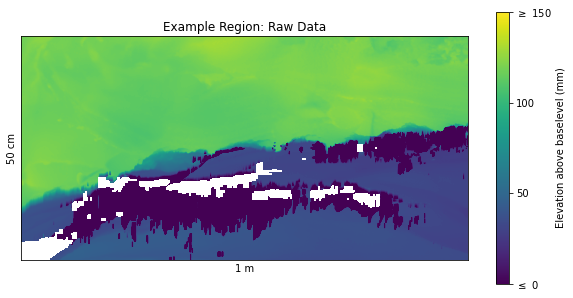

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot first scan
im = ax.imshow(raw_data[:,:,0], vmin=0, vmax=150)

# Make colorbar
cb = plt.colorbar(im)
cb.set_label('Elevation above baselevel (mm)')
cb.set_ticks([0, 50, 100, 150])
cb.set_ticklabels([r'$\leq$ 0', 50, 100, r'$\geq$ 150'])

# Crop to example region
ax.set_xlim(500, 1500)
ax.set_ylim(700, 200)

# Format figure
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('1 m')
ax.set_ylabel('50 cm')
ax.set_title('Example Region: Raw Data')

# Identify bad data by threshold elevation and gradient

Elevations less than zero and greater than 15 cm are not possible.

Eliminating pixels with gradients larger than 5 (i.e. the difference between adjacent pixels is larger than 5 mm) and then interpolating eliminates isolated bad datapoints while preserving near-vertical regions of topography created by undercutting and bank collapse.

In [5]:
def clean_scans(raw):
    
    # Make a copy
    cleaned = raw.copy()
    
    # assign numeric value to nan
    cleaned[np.isnan(cleaned)] = -9999
    
    # set impossible data to consistent value
    cleaned[cleaned < 0] = -9999
    cleaned[cleaned > 150] = -9999

    # calculate gradient and label regios that are surrounded by large gradients (islands)
    grad = sobel(cleaned)
    cleaned[grad>5] = -9999
    
    # return negative values to nan
    cleaned[cleaned<=0] = np.nan
    
    return grad, cleaned

# Run and store results
filtered = np.empty_like(raw_data)
gradient = np.empty_like(raw_data)
for i in range(9):
    gradient[:,:,i], filtered[:,:,i] = clean_scans(raw_data[:,:,i])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


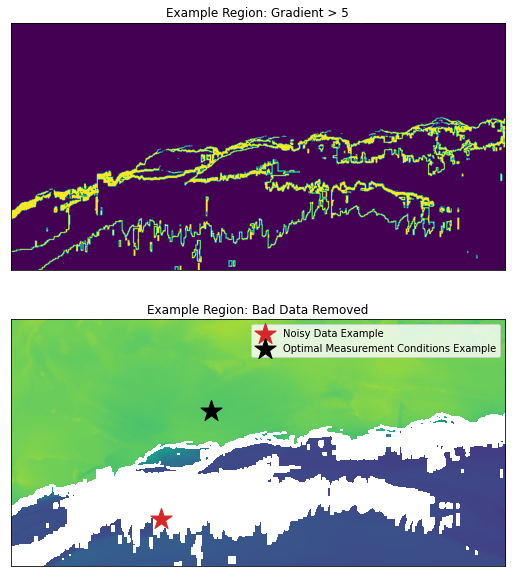

In [6]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

# Plot regions identified by threshold gradient
ax[0].set_title('Example Region: Gradient > 5')
ax[0].imshow(gradient[:,:,0]>5)

# Plot cleaned data
ax[1].set_title('Example Region: Bad Data Removed')
ax[1].imshow(filtered[:,:,0], vmin=0, vmax=150)


for i in [0,1]:
    # Crop to example region
    ax[i].set_xlim(500, 1500)
    ax[i].set_ylim(700, 200)
    
    # Format axes
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Plot example locations for subsequent analysis
ax[1].scatter(805, 605, marker='*', s=500, c=sns.color_palette()[3], label='Noisy Data Example')
ax[1].scatter(905, 385, marker='*', s=500, c='k', label='Optimal Measurement Conditions Example')
ax[1].legend()

# Downsample to 1 cm resolution

Initially, all measurements (up to 900 per 1 cm $\times$ 1 cm cell) are retained.

In [7]:
def downsample(arr, resratio):
    newshape = [arr.shape[0]//resratio, arr.shape[1]//resratio, 9*resratio**2]
    out = np.empty(newshape)
    for i in range(newshape[0]):
        for j in range(newshape[1]):
            out[i,j] = arr[i*resratio:(i+1)*resratio, j*resratio:(j+1)*resratio].ravel()
            
    return out

original_resolution = 1 # mm per px
downsampled_resolution = 10 # mm per px

resolution_ratio = downsampled_resolution // original_resolution  # must be integer

# run on filtered raw data
downsampled = downsample(filtered, resolution_ratio)

print(filtered.shape)
print(downsampled.shape)

(1501, 2688, 9)
(150, 268, 900)


# Merging samples to estimate bed elevation

We assume measurements of bed elevation $\eta'$ follow a normal distribution under optimal conditions i.e.:

$$
\eta' \sim \mathcal{N}(\eta, \sigma)
$$

where $\eta$ is the true bed elevation and $\sigma$ is the standard deviation of the measurement uncertainty.

We find that $\sigma \approx 0.5$ for regions where data quality is good. The figure below shows elevation measurements in the location of the black star above.

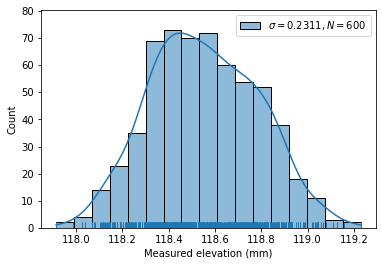

In [8]:
# Example data under optimal conditions in a region covered by 6 passes (N = 600)
sample = downsampled[90, 38]
fig, ax = plt.subplots()

sns.histplot(sample, ax=ax, kde=True, color=sns.color_palette()[0], 
             label=r'$\sigma = {:.4f}, N={:d}$'.format(np.nanstd(sample), len(sample[~np.isnan(sample)])))

sns.rugplot(sample, ax=ax, color=sns.color_palette()[0])

ax.set_xlabel('Measured elevation (mm)')
ax.legend()

## Outlier detection and averaging
Bed elevation is estimated by averaging points points that lie within the maximum density window of width $2\sigma$. In the example below, bed elevation is calculated for the location indicated by the red star above.

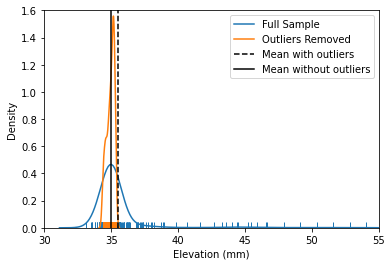

In [9]:
# Example application of outlier detection and averaging in a location with noisy data

# Get sample for starred location
sample = downsampled[60, 80]

# Sort and remove nans
ss = np.sort(sample[~np.isnan(sample)])

# Compute number of samples between val and val+2std for every sample value
std = 0.25 #mm
counts = [np.sum((ss > sample_i) & (ss < sample_i+4*std)) for sample_i in ss]

# Get argument of maximum (corresponds to lower bound of window)
arg0 = np.argmax(counts)

# Value of lower bound
minrng = ss[arg0]

# Value of upper bound
maxrng = minrng+4*std

# Argument of first element that is larger than upper bound (indexing goes to arg1 - 1)
arg1 = np.argmax(ss>maxrng)

if arg1==0: # occurs when largest sample is within the range
    subsamp = ss[arg0:]
else:
    subsamp = ss[arg0:arg1]

# Calculate mean with outliers
badmean = np.nanmean(ss)

# Calculate mean without outliers
mean = np.nanmean(subsamp)

fig, ax = plt.subplots()
sns.kdeplot(ss, ax=ax, label='Full Sample', color=sns.color_palette()[0])
sns.kdeplot(subsamp, ax=ax, label = 'Outliers Removed', color=sns.color_palette()[1])
sns.rugplot(ss, ax=ax, c=sns.color_palette()[0])
sns.rugplot(subsamp, ax=ax, c=sns.color_palette()[1])

ax.plot([badmean, badmean], [0, 1.6], 'k--', label='Mean with outliers')
ax.plot([mean, mean], [0, 1.6], 'k', label='Mean without outliers')
ax.set_ylim(0, 1.6)
ax.set_xlim(30, 55)
ax.set_xlabel('Elevation (mm)')
ax.legend()

In [10]:
# Implements logic above as a function
def calcmean(sample, std):
    ss = np.sort(sample[~np.isnan(sample)])
    
    if len(ss)==0:
        return np.nan, 0
    
    else:
        counts = [np.sum((ss > sample_i) & (ss < sample_i+4* std)) for sample_i in ss]
        arg0 = np.argmax(counts)
        minrng = ss[arg0]
        arg1 = np.argmax(ss>minrng+4*std)
        count = counts[arg0]
        
        if arg1==0:
            subsamp = ss[arg0:]
        else:
            subsamp = ss[arg0:arg1]
            
        mean = np.nanmean(subsamp)

        return mean, count

In [11]:
# Create empty arrays for elevation and sample size information
elev = np.empty_like(downsampled[:,:,0])
count = np.empty_like(elev)

# iterate all locations
for ix in tqdm(range(elev.size)):
    
    # unpack indices (necessary to track progress with tqdm)
    i, j = ix//downsampled.shape[1], ix%downsampled.shape[1]
    
    # calculate and store mean elevation and sample size
    elev[i,j], count[i,j] = calcmean(downsampled[i,j], std=0.25)

100%|███████████████████████████████████████████████████████████████████████████| 40200/40200 [04:50<00:00, 138.37it/s]


# Filtering bad elevation estimates based on sample size

The number of samples contributing to the average after removing outliers is good measure of data quality. Every location on the bed has the potential for between 300 and 900 measurements. A threshold minimum of 30 measurements provides a good balance between eliminating bad data and preserving good data.

In [12]:
# Create a copy
filtered_elev = elev.copy()

# Set elevations where n < 30 to nan
filtered_elev[count<30] = np.nan

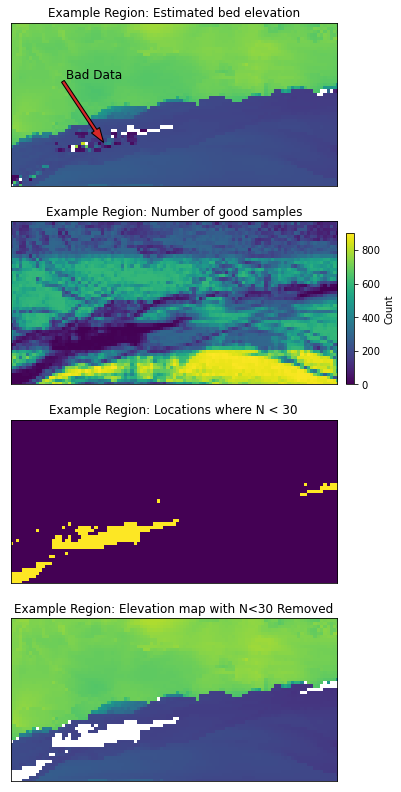

In [13]:
fig, ax = plt.subplots(nrows=4, figsize=(6,14), sharex = True, sharey=True)

# Plot elevation estimates from above
ax[0].set_title('Example Region: Estimated bed elevation')
ax[0].imshow(elev, vmin=0, vmax=150)

# Plot arrow indicating bad data
ax[0].arrow(66, 38, 10, 15, width=1, facecolor=sns.color_palette()[3])
ax[0].text(67, 37, 'Bad Data', size=12)

# Plot sample size map
ax[1].set_title('Example Region: Number of good samples')
im1=ax[1].imshow(count)

# make colorbar for sample size
plt.subplots_adjust(right=0.88)
cax = plt.axes([0.9, 0.52, 0.02, 0.15])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=900)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb1.set_label('Count')

# Plot regions identified by threshold sample size
ax[2].set_title('Example Region: Locations where N < 30')
ax[2].imshow(count<30)

# Plot cleaned elevation data 
ax[3].set_title('Example Region: Elevation map with N<30 Removed')
ax[3].imshow(filtered_elev)

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(70, 20)
    

# Fill missing values

Missing elevation values are filled using adjacent valid elevations from the same cross section. Using the minimum adjacent elevation (rather than interpolating linearly) produces the best results because missing values tend to be located next to large elevation differences.

In [14]:
def interp_nans(Zin):
    
    # Create empty array with correct shape
    Zout = np.empty_like(Zin)
    
    # Iterate over all positions
    for i in range(Zin.shape[0]):
        for j in range(Zin.shape[1]):
            
            # If the value is missing...
            if np.isnan(Zin[i,j]):
                
                # Get list of elevations moving left and right from target location
                Zright = Zin[i+1:,j]
                Zleft = Zin[i-1::-1,j]
                
                # Get first valid elevation to right
                if len(Zright > 0) and (~np.isnan(Zright)).any():
                    Z1 = Zright[np.argmax(~np.isnan(Zright))]
                else:
                    Z1 = np.nan
                
                # Get first valid elevation to left
                if (len(Zleft)> 0) and (~np.isnan(Zleft)).any():
                    Z2 = Zleft[np.argmax(~np.isnan(Zleft))]
                else:
                    Z2 = np.nan

                # Assign minimum
                Zout[i,j] = np.nanmin([Z1, Z2])

            else:
                Zout[i,j] = Zin[i,j]

    return Zout

# Apply to filtered 
Zfinal = interp_nans(filtered_elev)

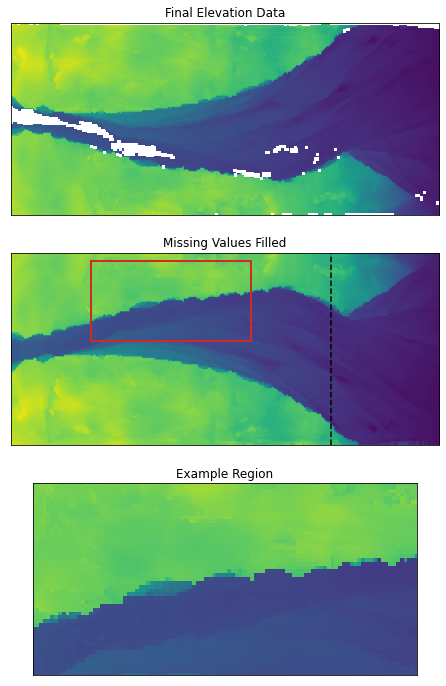

In [15]:
fig, ax = plt.subplots(nrows=3, figsize=(8,12))

# Plot elevation data with N<30 removed
ax[0].set_title('Final Elevation Data')
ax[0].imshow(filtered_elev, vmin=0, vmax=150)
ax[0].set_ylim(15, 135)

# Plot elevation data with missing values filled
ax[1].set_title('Missing Values Filled')
ax[1].imshow(Zfinal, vmin=0, vmax=150)
ax[1].set_ylim(135, 15)
ax[1].plot([200, 200], [135, 15], 'k--')

# Plot rectangle corresponding to example region above
ax[1].add_patch(mpl.patches.Rectangle((50, 20),
                            100, 50,
                            fc ='none', 
                            ec = sns.color_palette()[3],
                            lw = 2))

# Plot example region filled
ax[2].set_title('Example Region')
ax[2].imshow(Zfinal, vmin=0, vmax=150)
ax[2].set_xlim(50, 150)
ax[2].set_ylim(70, 20)

for i in [0,1,2]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Plot an example cross-section

Corresponds to the black dashed line in the previous figure

(0.0, 120.0)

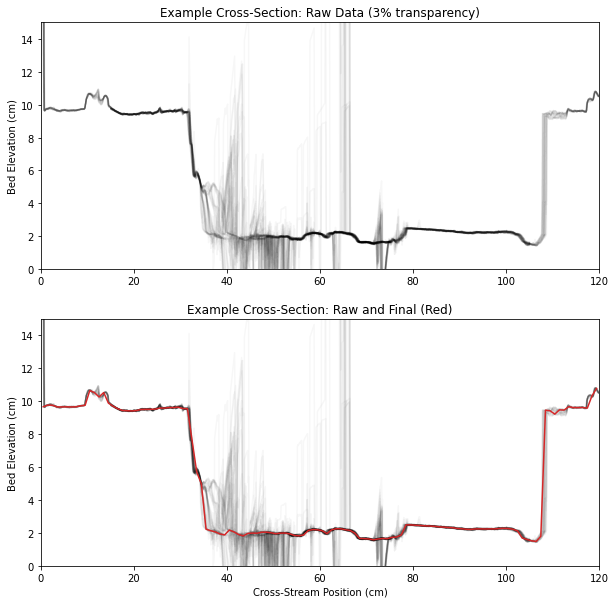

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

# Plot raw data
for i in range(9):
    for j in range(10):
        ax[0].plot(np.linspace(0.05, 119.95, 1200), raw_data[150:1350, 2000+j, i]/10, c='k', alpha=0.03)
        ax[1].plot(np.linspace(0.05, 119.95, 1200), raw_data[150:1350, 2000+j, i]/10, c='k', alpha=0.03)

# Plot final data
ax[1].plot(np.linspace(0.5, 119.5, 120), Zfinal[15:135,200]/10, c=sns.color_palette()[3])


ax[0].set_title('Example Cross-Section: Raw Data (3% transparency)')
ax[1].set_title('Example Cross-Section: Raw and Final (Red)')

ax[0].set_ylabel('Bed Elevation (cm)')
ax[1].set_ylabel('Bed Elevation (cm)')
ax[1].set_xlabel('Cross-Stream Position (cm)')

ax[0].set_ylim(0, 15)
ax[0].set_xlim(0, 120)
ax[1].set_ylim(0, 15)
ax[1].set_xlim(0, 120)